In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Y_1.jgp
# N_1.jpg

import os

folder = "/datasets/yes"
count = 1

for filename in os.listdir(folder):
    source = os.path.join(folder, filename)
    destination = os.path.join(folder, "Y_" + str(count) + ".jpg")
    os.rename(source, destination)
    count += 1

print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [ ]:
folder = "/datasets/no"
count = 1

for filename in os.listdir(folder):
    source = os.path.join(folder, filename)
    destination = os.path.join(folder, "N_" + str(count) + ".jpg")
    os.rename(source, destination)
    count += 1

print("All files are renamed in the no dir.")

All files are renamed in the no dir.


### EDA(Exploratory Data Analysis)

In [ ]:
listyes= os.listdir("/datasets/yes")
number_files_yes = len(listyes)
print(number_files_yes)

listno= os.listdir("/datasets/no")
number_files_no = len(listno)
print(number_files_no)

5434
4174


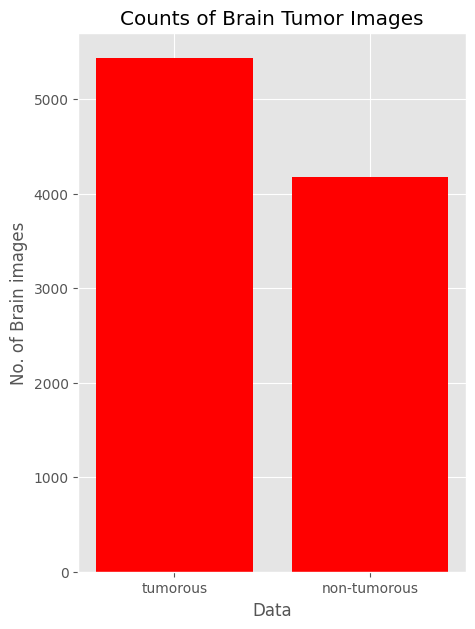

In [ ]:
data= {'tumorous': number_files_yes, 'non-tumorous':number_files_no}

typex = data.keys()
values = data.values()

fig =plt.figure(figsize=(5,7))

plt.bar(typex, values,color ='red')

plt.xlabel("Data")
plt.ylabel("No. of Brain images")
plt.title("Counts of Brain Tumor Images")
plt.show()

### Data Augumentation

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 

In [ ]:
import os
import cv2
import time

def augmented_data(file_dir, n_generated_samples, save_to_dir):
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)  # Create the directory if it doesn't exist

    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(os.path.join(file_dir, filename))
        image = image.reshape((1,) + image.shape)
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

start_time = time.time()

yes_path = "/datasets/yes"
no_path = "/datasets/no"

augmented_data_path = "/content/drive/MyDrive/datasets/augmented_data"

augmented_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=os.path.join(augmented_data_path, 'yes'))
augmented_data(file_dir=no_path, n_generated_samples=9, save_to_dir=os.path.join(augmented_data_path, 'no'))

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time)


In [ ]:
import os

def data_summary(main_path):
    yes_path = "/datasets/augmented_data/yes/"
    no_path = "/datasets/augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = n_pos + n_neg

    pos_per = (n_pos * 100) / n
    neg_per = (n_neg * 100) / n

    print(f"Number of samples: {n}")
    print(f"Number of positive samples: {n_pos} ({pos_per:.2f}%)")
    print(f"Number of negative samples: {n_neg} ({neg_per:.2f}%)")

# Assuming augmented_data_path is defined somewhere in your code
augmented_data_path = "/datasets/augmented_data"
data_summary(augmented_data_path)


Number of samples: 19643
Number of positive samples: 9785 (49.81%)
Number of negative samples: 9858 (50.19%)


In [ ]:
import os

list_yes = os.listdir("/datasets/augmented_data/yes")
number_files_yes = len(list_yes)
print(number_files_yes)

list_no = os.listdir("/datasets/augmented_data/no")
number_files_no = len(list_no)
print(number_files_no)

9785
9858


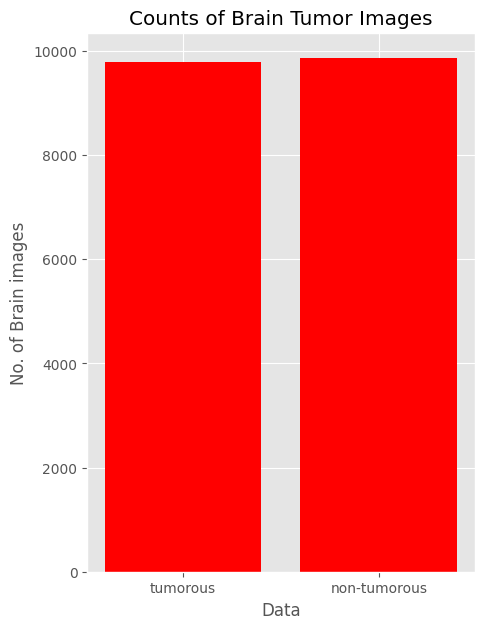

In [ ]:
import matplotlib.pyplot as plt
data= {'tumorous': number_files_yes, 'non-tumorous':number_files_no}

typex = data.keys()
values = data.values()

fig =plt.figure(figsize=(5,7))

plt.bar(typex, values,color ='red')

plt.xlabel("Data")
plt.ylabel("No. of Brain images")
plt.title("Counts of Brain Tumor Images")
plt.show()

### Data Preprocessing

In [ ]:
# covert BGR to GRAY
# GaussianBlue
# Threshold
# Erode
# Dilate
# Find Contours

In [3]:
import imutils

In [4]:
import cv2
import imutils
import matplotlib.pyplot as plt

def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
    gray = cv2.GaussianBlur(gray, (5, 5), 0)  # Apply Gaussian blur

    thres = cv2.threshold(gray, 45, 224, cv2.THRESH_BINARY)[1]  # Thresholding
    thres = cv2.erode(thres, None, iterations=2)  # Erosion
    thres = cv2.dilate(thres, None, iterations=2)  # Dilation

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])  # Corrected to use y-coordinate for top
    extBot = tuple(c[c[:,:,1].argmax()][0])  # Corrected variable name

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')

        plt.show()

    return new_image


In [ ]:
img = cv2.imread("/datasets/augmented_data/yes/aug_0_0.jpg")
crop_brain_tumor(img, True)

In [ ]:
img = cv2.imread("/datasets/no/aug_0_0.jpg")
crop_brain_tumor(img, True)

In [ ]:
#Cropping the augmented_data
import os
import cv2

folder1 = "/datasets/augmented_data/no"
folder2 = "/datasets/augmented_data/yes"

for filename in os.listdir(folder1):
    img = cv2.imread(os.path.join(folder1, filename))
    img = crop_brain_tumor(img, False)
    cv2.imwrite(os.path.join(folder1, filename), img)

for filename in os.listdir(folder2):
    img = cv2.imread(os.path.join(folder2, filename))
    img = crop_brain_tumor(img, False)
    cv2.imwrite(os.path.join(folder2, filename), img)

In [6]:
#Cropping the original_data

import os
import cv2

folder3 = "datasets/no"
folder4 = "datasets/yes"


for filename in os.listdir(folder3):
    file_path = os.path.join(folder3, filename)
    img = cv2.imread(file_path)
    if img is None:
        print("Error: Unable to read image:", file_path)
        continue
    img = crop_brain_tumor(img, False)
    cv2.imwrite(file_path, img)

for filename in os.listdir(folder4):
    file_path = os.path.join(folder4, filename)
    img = cv2.imread(file_path)
    if img is None:
        print("Error: Unable to read image:", file_path)
        continue
    img = crop_brain_tumor(img, False)
    cv2.imwrite(file_path, img)


Error: Unable to read image: datasets/no/N_646.jpg
Error: Unable to read image: datasets/yes/Y_812.jpg


In [7]:
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    x = []
    y = []

    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 224.0  # Normalize

            x.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)

    x = np.array(x)
    y = np.array(y)

    x, y = shuffle(x, y)

    print(f"Number of examples is: {len(x)}")
    print(f"X shape is: {x.shape}")
    print(f"y shape is: {y.shape}")

    return x, y

In [8]:
import os
import shutil

# Define the paths to the source and destination folders
source_folder = "datasets/no"  # Path to the source folder
destination_folder = "datasets/augmented_data/no"  # Path to the destination folder

# Get the list of files in the source folder
files = os.listdir(source_folder)

# Iterate over each file and move it to the destination folder
for file_name in files:
    # Get the full path of the file
    source_file_path = os.path.join(source_folder, file_name)
    # Check if the file is a regular file
    if os.path.isfile(source_file_path):
        # Move the file to the destination folder
        shutil.move(source_file_path, destination_folder)
    else:
        print(f"{file_name} is not a regular file. Skipping...")

In [9]:
import os
import shutil

# Define the paths to the source and destination folders
source_folder = "datasets/yes"  # Path to the source folder
destination_folder = "datasets/augmented_data/yes"  # Path to the destination folder

# Get the list of files in the source folder
files = os.listdir(source_folder)

# Iterate over each file and move it to the destination folder
for file_name in files:
    # Get the full path of the file
    source_file_path = os.path.join(source_folder, file_name)
    # Check if the file is a regular file
    if os.path.isfile(source_file_path):
        # Move the file to the destination folder
        shutil.move(source_file_path, destination_folder)
    else:
        print(f"{file_name} is not a regular file. Skipping...")

In [10]:
import os

combined_no_folder = "datasets/augmented_data/no"
combined_yes_folder = "datasets/augmented_data/yes"

def count_files(folder):
    return len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))])

num_combined_no = count_files(combined_no_folder)
num_combined_yes = count_files(combined_yes_folder)

print("Number of images in combined 'no' dataset:", num_combined_no)
print("Number of images in combined 'yes' dataset:", num_combined_yes)

Number of images in combined 'no' dataset: 14032
Number of images in combined 'yes' dataset: 15218


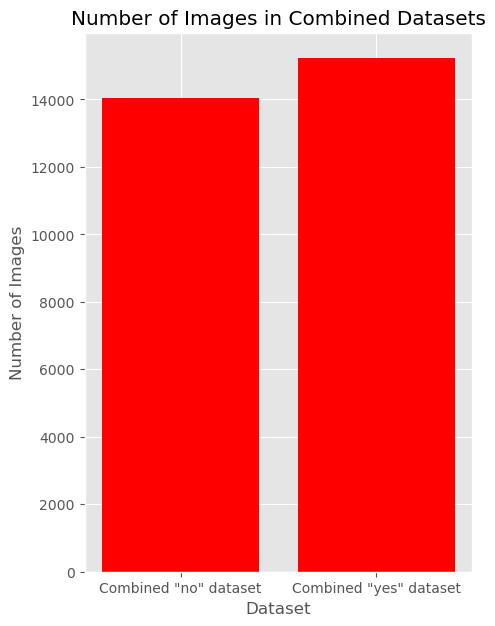

In [12]:
#Visualizing combined datasets
import os
import matplotlib.pyplot as plt

labels = ['Combined "no" dataset', 'Combined "yes" dataset']
values = [num_combined_no, num_combined_yes]

plt.figure(figsize=(5,7))
plt.bar(labels, values, color='red')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in Combined Datasets')
plt.show()


In [13]:
def load_data(dir_list, image_size, batch_size=1000):
    X_batches = []
    y_batches = []

    for directory in dir_list:
        X = []
        y = []
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                img = cv2.imread(file_path)
                if img is None:
                    print(f"Error: Unable to read image '{file_path}'")
                    continue

                img = cv2.resize(img, image_size)
                X.append(img)
                if "yes" in directory:
                    y.append(1)
                else:
                    y.append(0)
                if len(X) == batch_size:
                    X_batches.append(np.array(X))
                    y_batches.append(np.array(y))
                    X = []
                    y = []
            except Exception as e:
                print(f"Error processing image '{file_path}': {str(e)}")
        if len(X) > 0:
            X_batches.append(np.array(X))
            y_batches.append(np.array(y))

    X = np.concatenate(X_batches)
    y = np.concatenate(y_batches)
    print(f"Number of examples is: {len(X)}")
    print(f"X shape is: {X.shape}")
    print(f"y shape is: {y.shape}")

    return X, y


Error: Unable to read image 'datasets/augmented_data/no/N_646.jpg'
Error: Unable to read image 'datasets/augmented_data/yes/Y_812.jpg'
Number of examples is: 29248
X shape is: (29248, 224, 224, 3)
y shape is: (29248,)


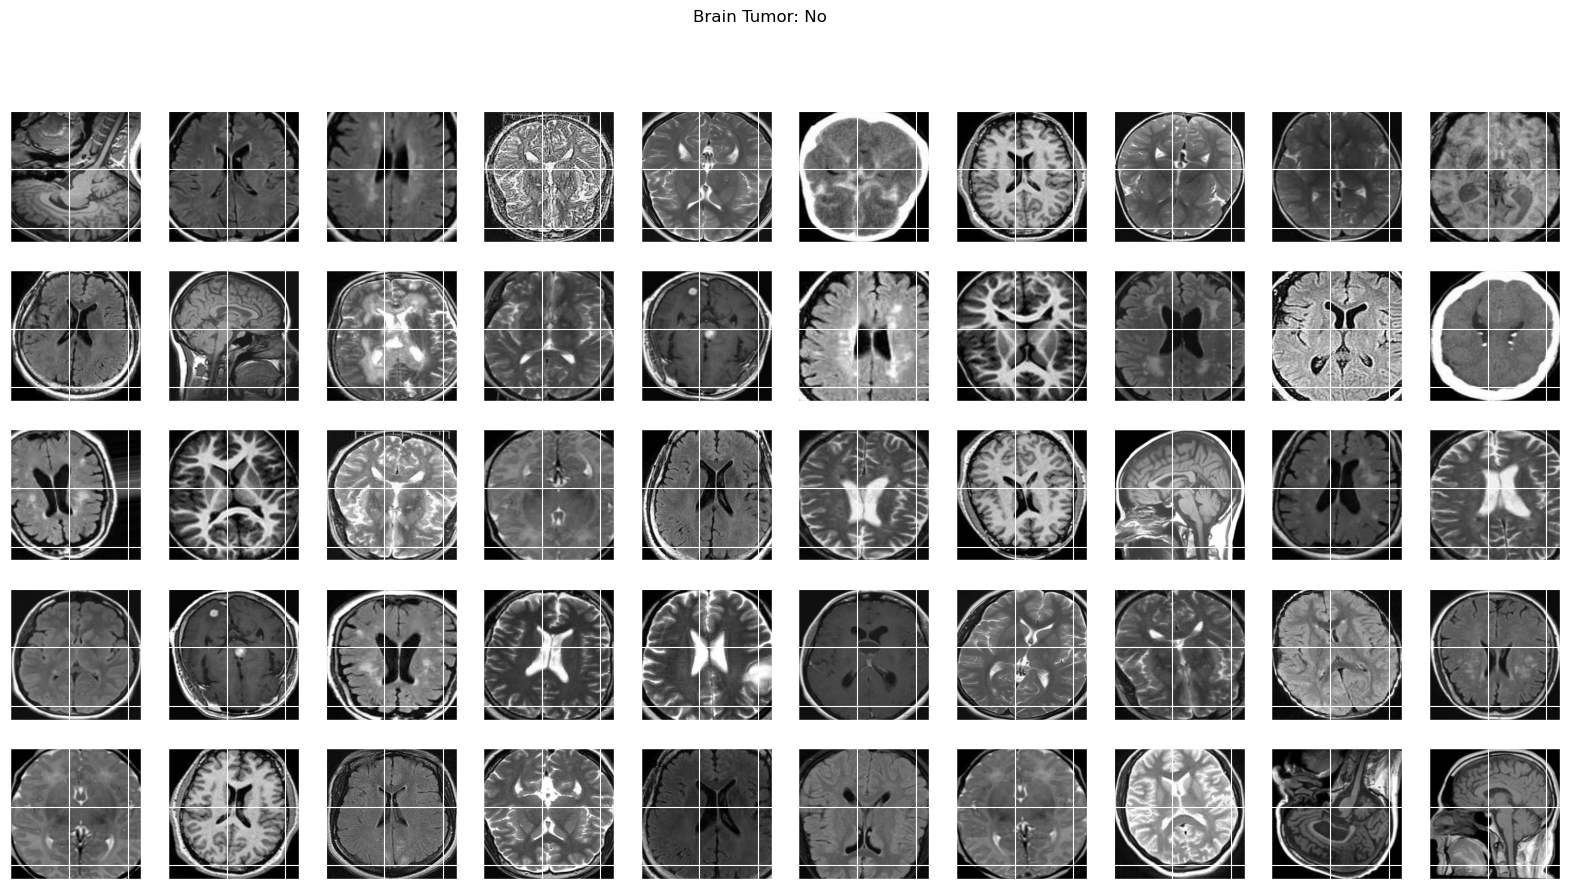

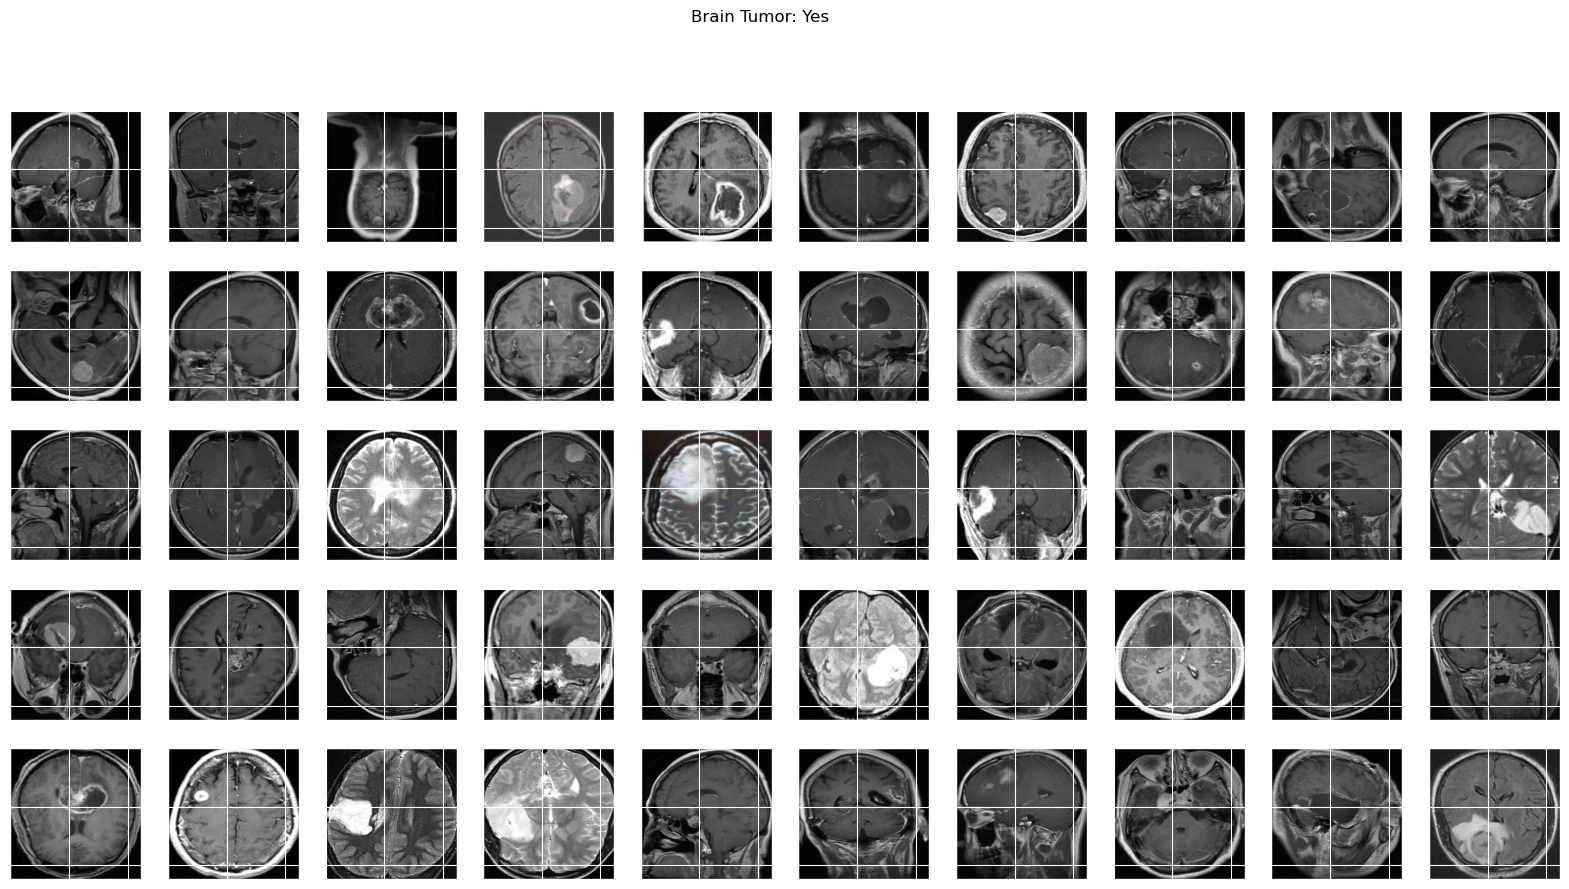

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the load_data function

# Define the plot_sample_images function
def plot_sample_images(X, y, n=50):
    for label in [0, 1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n / columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

# Define paths and other necessary variables
augmented_path = "datasets/augmented_data/"
combined_yes = augmented_path + 'yes'
combined_no = augmented_path + 'no'
IMAGE_WIDTH, IMAGE_HEIGHT = (224, 224)

# Load data
X, y = load_data([combined_no,combined_yes], (IMAGE_WIDTH, IMAGE_HEIGHT))

# Plot sample images
plot_sample_images(X, y)


### Data Splitting

In [16]:
import os
import shutil
import random

yes_data_dir = "datasets/augmented_data/yes/"
no_data_dir = "datasets/augmented_data/no/"

train_dir = "datasets/train/"
val_dir = "datasets/validation/"

for directory in [train_dir, val_dir]:
    os.makedirs(directory, exist_ok=True)

train_ratio = 0.8
val_ratio = 0.2

def split_data(source, dest_train, dest_val, ratio):
    files = os.listdir(source)
    random.shuffle(files)
    num_files = len(files)

    train_end = int(num_files * ratio)
    val_end = int(num_files * (ratio + 0.20))

    train_files = files[:train_end]
    val_files = files[train_end:val_end]

    for file in train_files:
        shutil.copy(os.path.join(source, file), os.path.join(dest_train, file))
    for file in val_files:
        shutil.copy(os.path.join(source, file), os.path.join(dest_val, file))


split_data(yes_data_dir, train_dir + 'yes', val_dir + 'yes',  train_ratio)
split_data(no_data_dir, train_dir + 'no', val_dir + 'no',  train_ratio)

In [17]:
train_count_yes = count_files(os.path.join(train_dir, 'yes'))
train_count_no = count_files(os.path.join(train_dir, 'no'))

val_count_yes = count_files(os.path.join(val_dir, 'yes'))
val_count_no = count_files(os.path.join(val_dir, 'no'))

print("Train - Yes:", train_count_yes)
print("Train - No:", train_count_no)
print("Validation - Yes:", val_count_yes)
print("Validation - No:", val_count_no)

Train - Yes: 12174
Train - No: 11225
Validation - Yes: 3044
Validation - No: 2807
